# LAM Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import sklearn
import sklearn.model_selection as sklms
import sklearn.linear_model as skllm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier


from lam import ar, fft, ssa, semor
from lam import utils

from ensemble import Ensemble

from tqdm.notebook import tqdm

### Loading and preprocessing data

In [2]:
with open("data/manual/data/segments.pickle", "rb") as f:
    segments_dict = pickle.load(f)

In [3]:
action_and_segment = []

for key, segments_array in segments_dict.items():
    action_and_segment.extend([(key, s) for s in segments_array if s.size > 30])

segments = [pair[1] for pair in action_and_segment]
actions = [pair[0] for pair in action_and_segment]

normalized_segments = utils.normalize_segments(segments)

le = LabelEncoder()
Y = le.fit_transform(actions)

X = np.array(normalized_segments)

print('Data shape:', X.shape)
print('Labels shape:', Y.shape)

Data shape: (215, 31)
Labels shape: (215,)


#### Data shuffling

In [4]:
a = np.arange(0, X.shape[0])
np.random.shuffle(a)

X = X[a]
Y = Y[a]

### Making an ensemble

In [5]:
with open("data/semor_profiles/semor_profiles.pickle", "rb") as f:
    semor_profiles = pickle.load(f)

for key, profile in semor_profiles.items():
    semor_profiles[key] = utils.shrink_segment(profile, 20)

In [6]:
ens = Ensemble([ar.AR(5),
                fft.FFT(4),
                ssa.SSA(10),
                semor.Semor(semor_profiles['walk']),
                semor.Semor(semor_profiles['run']),
                semor.Semor(semor_profiles['up']),
                semor.Semor(semor_profiles['down'])])

print([model.name for model in ens.models])

['ar_5', 'fft_4', 'ssa_10', 'semor_257', 'semor_669', 'semor_964', 'semor_779']


In [7]:
ens.fit(X)

/home/danillich/.local/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarn

#### Ensembe parameters

In [8]:
ens.params.shape

(215, 40)

### Passing parameters to NN classifier

In [9]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = []
accs = []

for train_idx, test_idx in tqdm(kfold.split(ens.params, Y), total=10):
    x_train, x_test = ens.params[train_idx], ens.params[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    model = skllm.LogisticRegression(max_iter=15000)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    scores.append(sklearn.metrics.log_loss(y_test, y_pred))
    accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
    
print('Average accuracy:', np.mean(accs))
print('Average loss:', np.mean(scores))
print('Loss std:', np.std(scores))

/home/danillich/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Average accuracy: 0.9166666666666667
Average loss: 0.46128662653907854
Loss std: 0.352441584641223


In [10]:
list(zip(accs, scores))

[(0.9545454545454546, 0.3538549559070722),
 (0.8636363636363636, 0.9365371684184173),
 (0.8181818181818182, 1.2359242989229446),
 (0.9090909090909091, 0.30171338808850096),
 (0.9545454545454546, 0.20142213032561898),
 (1.0, 0.04256645180542136),
 (0.8571428571428571, 0.549906913461208),
 (0.9047619047619048, 0.2801921701447716),
 (0.9523809523809523, 0.1639596323465385),
 (0.9523809523809523, 0.5467891559702914)]

### Passing parameters to 2NN classifier

In [11]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = []
accs = []

for train_idx, test_idx in tqdm(kfold.split(ens.params, Y), total=10):
    x_train, x_test = ens.params[train_idx], ens.params[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    model = MLPClassifier(hidden_layer_sizes=(60), max_iter=5000, activation='logistic')
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    scores.append(sklearn.metrics.log_loss(y_test, y_pred))
    accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
    
print('Average accuracy:', np.mean(accs))
print('Average loss:', np.mean(scores))
print('Loss std:', np.std(scores))


Average accuracy: 0.9396103896103897
Average loss: 0.2007842685974252
Loss std: 0.1290945923370438


In [12]:
list(zip(accs, scores))

[(0.9545454545454546, 0.1975507367894216),
 (0.9090909090909091, 0.2952264053909483),
 (0.8181818181818182, 0.4824252622071301),
 (1.0, 0.04701173056594943),
 (1.0, 0.05277170243147413),
 (1.0, 0.05967297784939364),
 (0.9523809523809523, 0.24035558212767333),
 (0.9047619047619048, 0.29637901994522603),
 (0.9047619047619048, 0.1607379456018264),
 (0.9523809523809523, 0.17571132306520929)]

# Baseline NN + NN classfifier

In [13]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = []
accs = []

n_hid_features = ens.params.shape[1]
n_hid_features = 100

for train_idx, test_idx in tqdm(kfold.split(X, Y), total=10):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    model = MLPClassifier(hidden_layer_sizes=(n_hid_features), max_iter=5000, activation='logistic')
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    scores.append(sklearn.metrics.log_loss(y_test, y_pred))
    accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
    
print('Average accuracy:', np.mean(accs))
print('Average loss:', np.mean(scores))
print('Loss std:', np.std(scores))


Average accuracy: 0.879004329004329
Average loss: 0.3839363513344748
Loss std: 0.169895821738764


In [14]:
list(zip(accs, scores))

[(0.9545454545454546, 0.160677469831277),
 (0.8636363636363636, 0.552347357965359),
 (0.7272727272727273, 0.5348462748221415),
 (0.9090909090909091, 0.305399184254056),
 (0.9545454545454546, 0.11183353219314895),
 (0.9047619047619048, 0.2482955992122581),
 (0.8571428571428571, 0.5221259808574545),
 (0.9523809523809523, 0.2921365345035005),
 (0.8571428571428571, 0.5210217125079832),
 (0.8095238095238095, 0.5906798671975685)]

# Baseline NN + 2NN classfifier

In [15]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = []
accs = []

n_hid_features = ens.params.shape[1]

for train_idx, test_idx in tqdm(kfold.split(X, Y), total=10):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    model = MLPClassifier(hidden_layer_sizes=(100, n_hid_features), max_iter=5000, activation='logistic')
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    scores.append(sklearn.metrics.log_loss(y_test, y_pred))
    accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])

print('Average accuracy:', np.mean(accs))
print('Average loss:', np.mean(scores))
print('Loss std:', np.std(scores))


Average accuracy: 0.865151515151515
Average loss: 0.4239846662932031
Loss std: 0.16681417329219622


In [16]:
list(zip(accs, scores))

[(0.8636363636363636, 0.28540994723664315),
 (0.8181818181818182, 0.4441591157492482),
 (0.7727272727272727, 0.5717847803649971),
 (0.9090909090909091, 0.2689297669271284),
 (0.9545454545454546, 0.13663735077600023),
 (0.9047619047619048, 0.29135985165845774),
 (0.9047619047619048, 0.6306153702260675),
 (0.8571428571428571, 0.39190810003932114),
 (0.8571428571428571, 0.6141173328381226),
 (0.8095238095238095, 0.6049250471160449)]

# Ensemble with LASSO

In [17]:
params = ens.params.copy()
labels = Y.copy()

for i in range(params.shape[1]):
    tmp = np.linalg.norm(params[:, i])
    if tmp > 0:
        params[:, i] /= tmp 
labels = labels/np.linalg.norm(labels)

X_train, X_test, y_train, y_test = sklms.train_test_split(params, labels, test_size=0.3, random_state=42)

In [18]:
lasso = skllm.LassoCV(cv=5, max_iter=5000)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [19]:
lasso.coef_

array([ 0.00000000e+00,  2.81230544e-01, -6.03628525e-02, -7.69210616e-02,
       -2.56637057e-01, -2.24611130e-01,  0.00000000e+00,  0.00000000e+00,
        2.49561867e-01,  3.90426617e-15, -1.91343030e+00, -4.06381022e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.27815620e-01,
        1.85405509e-01,  0.00000000e+00,  2.13815569e-01, -0.00000000e+00,
        0.00000000e+00, -5.38589443e-03, -9.93059019e-02, -0.00000000e+00,
       -6.85049864e-01,  0.00000000e+00,  1.63345674e-02,  2.83496659e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.09666334e-01,
       -6.22806780e-02,  0.00000000e+00, -3.46331121e-01,  0.00000000e+00,
        3.15132304e-01,  1.16843634e-01, -0.00000000e+00,  1.37413137e+00])

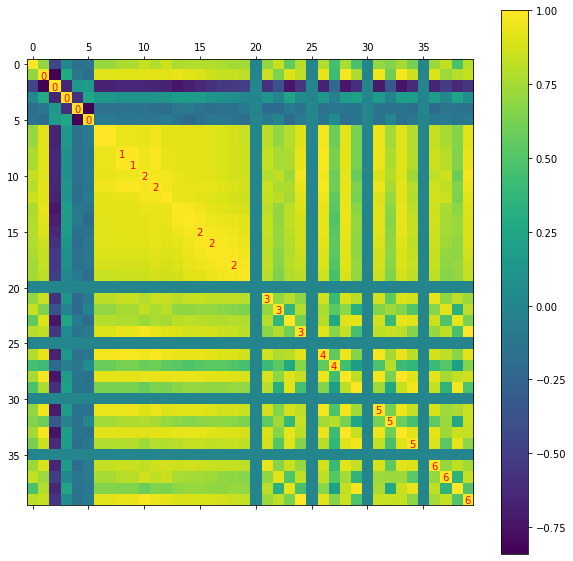

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.matshow(params.T.dot(params))

for ind in range(params.T.dot(params).shape[1]):
    if lasso.coef_[ind] != 0:
        ax.text(ind, ind, ens.models_indices[ind], va='center', ha='center', fontdict={'color': 'red'})

fig.colorbar(im)
plt.show()

In [21]:
y_pred = lasso.predict(X_test)
np.linalg.norm(y_pred - y_test)**2

0.026673306614095393

In [22]:
lasso.score(X_test, y_test)

0.6405858331386911

In [23]:
lasso.score(X_train, y_train)

0.6765928544187462

In [24]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = []
accs = []

for train_idx, test_idx in tqdm(kfold.split(ens.params, Y), total=10):
    x_train, x_test = ens.params[train_idx], ens.params[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    for i in range(lasso.coef_.shape[0]):
        if lasso.coef_[i] == 0:
            x_train[:, i] = np.zeros_like(x_train[:, i])
            x_test[:, i] = np.zeros_like(x_test[:, i])
    
    model = skllm.LogisticRegression(max_iter=15000)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    scores.append(sklearn.metrics.log_loss(y_test, y_pred))
    accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
    
print('Average accuracy:', np.mean(accs))
print('Average loss:', np.mean(scores))
print('Loss std:', np.std(scores))

/home/danillich/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Average accuracy: 0.9214285714285715
Average loss: 0.33444194194562943
Loss std: 0.25932813960755124


In [25]:
model.coef_

array([[ 0.00000000e+00,  2.01503661e-01, -1.31290280e-01,
        -8.88553674e-02,  7.13763350e-02,  9.24986020e-02,
         0.00000000e+00,  0.00000000e+00, -3.94230986e-02,
        -3.94230986e-02,  4.73930270e-01,  6.28427438e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.70513349e-01, -5.14813713e-01,  0.00000000e+00,
        -5.68507928e-01,  0.00000000e+00,  0.00000000e+00,
        -1.33341575e-02, -5.06567933e-01,  0.00000000e+00,
        -5.38904034e-02,  0.00000000e+00, -2.99979453e-02,
         1.01236184e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.68983899e-02,  4.37238566e-06,
         0.00000000e+00,  4.05577689e-01,  0.00000000e+00,
        -2.30866906e-04, -1.96378908e-01,  0.00000000e+00,
        -4.13193167e-01],
       [ 0.00000000e+00, -3.38468541e-02,  7.80632320e-01,
        -1.13893499e-01, -2.83503358e-01,  1.68847932e-01,
         0.00000000e+00,  0.00000000e+00,  2.41319972e-02,
         2.41319972e-02, -2.83